In [171]:
type = "real_exp"
device = 'orin'
models = ["GPU >>> CPU", "GPU >> CPU", "GPU > CPU", "GPU > CPU | GPU < CPU"]
# model = models[3]
model = "densenet201"
date_label = "orin"

# Import

In [172]:
# 기본 세팅
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import gaussian_kde
from matplotlib import colors as mpl_colors
import os
import argparse
from datetime import datetime
from glob import glob
from itertools import product, groupby
from mpl_toolkits.mplot3d import Axes3D
import re

# Font & Color

##### TODO
- font download

In [173]:
# font = {'family': 'Tahoma'}
# font = {'family': 'Times New Roman'}

# plt.rc('font', **font)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
grid_color = 'gainsboro'

In [174]:
def layerNum(model:str) -> int:
    if model == "densenet201" :
        return 306
    elif model == "resnet152" :
        return 206
    elif model == "enetb0" :
        return 136
    elif model == "csmobilenet-v2" :
        return 81
    elif model == "squeezenet" :
        return 50
    elif model == "yolov7" :
        return 143
    elif model == "yolov7-tiny" :
        return 99
    elif model == "yolov4" :
        return 162
    elif model == "yolov4-tiny" :
        return 38
    elif model == "resnet10" :
        return 17
    elif model == "yolov2-tiny" :
        return 16
    else :
        print("Unknown model: ", model)
        return 0

def maxCore(device:str) -> int:
    if device == "nano":
        return 4
    elif device == "super":
        return 4
    elif device == "orin":
        return 10
    else:
        print("Unknown device: ", device)
        return 0

### Options

In [175]:
save_formats = ['png', 'pdf', 'svg']
devices = ['nano', 'orin', 'super']
types = ["toy_simul", "real_simul", "real_exp"]
models = ['densenet201', 'resnet152', 'enetb0', 'csmobilenet-v2', 'squeezenet', 
          'yolov7', 'yolov7-tiny', 'yolov4', 'yolov4-tiny', 'resnet10', 'yolov2-tiny']

max_cores = maxCore(device)
if type not in types:
    print("Unknown type: ", type)
layer_num = layerNum(model)
if not os.path.exists(f"../../csv/{date_label}"):
    print(f"Invalid date: {date_label}")

In [176]:
for save_format in save_formats:
    directory_path = f'./{date_label}/{save_format}'
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"디렉터리 '{directory_path}' 생성 완료!")
    else:
        print(f"디렉터리 '{directory_path}'가 이미 존재합니다.")

디렉터리 './orin/png'가 이미 존재합니다.
디렉터리 './orin/pdf'가 이미 존재합니다.
디렉터리 './orin/svg'가 이미 존재합니다.


### Load csv & Dataframe 생성

##### 1. toy_simul

In [177]:
if type == "toy_simul":
    models = ["GPU >>> CPU", "GPU >> CPU", "GPU > CPU", "GPU > CPU | GPU < CPU"]
    # model = models[2]
    max_cores = 10
    # max_cores = maxCore(device)
    if type not in types:
        print("Unknown type: ", type)
    contention_overhead_percent = 10

In [178]:
if type == "toy_simul":
    if model == "GPU >>> CPU":
        # GPU >>> CPU
        cpu_inference_list = [200,400,350,460,570,330,250,290,310,300]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif model == "GPU >> CPU":
        # GPU >>> CPU
        cpu_inference_list = [100,200,150,260,270,130,50,90,110,30]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif model == "GPU > CPU":
        # GPU > CPU
        cpu_inference_list = [10,20,15,26,27,13,5,9,11,3]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif model == "GPU > CPU | GPU < CPU":
        # # GPU CPU 반반 (앞이 GPU 효율 좋음)
        cpu_inference_list = [10,20,15,26,27,13,5,9,11,3]
        gpu_inference_list = [1,3,2,5,7,18,14,15,18,5]
    else: print("Unknown mode")
    layer_num = len(cpu_inference_list)

In [179]:
if type == "toy_simul":
    e_preprocess = 0
    e_postprocess = 0
    e_inference_cpu = sum(cpu_inference_list)
    e_inference_gpu = sum(gpu_inference_list)

In [180]:
if type == "toy_simul":
    # 데이터 저장을 위한 딕셔너리
    average_execution_times = {}
    throughput = {}
    block_losses = {}
    accel_gains = {}
    pre_components = {}
    infer_components = {}
    post_components = {}
    block_components = {}

    labels = ['Seq\n(Full CPU)', 'TPA\n(Full CPU)', 'DPA\n(Full CPU)',
              'Seq\n(Full GPU)', 'TPA\n(Full GPU)', 'DPA\n(Full GPU)']

In [181]:
if type == "toy_simul":
    # Calculations for Sequential (Full CPU)
    e_inference_cpu = sum(cpu_inference_list)
    delay_seq_cpu = e_preprocess + e_inference_cpu + e_postprocess
    average_execution_times["Seq\n(Full CPU)"] = delay_seq_cpu

    throughput["Seq\n(Full CPU)"] = 1 / delay_seq_cpu * 1000

    block_loss_seq_cpu = 0
    block_losses["Seq\n(Full CPU)"] = block_loss_seq_cpu



    # Calculations for Pipeline (Full CPU)
    max_stage_cpu = max(e_preprocess, e_inference_cpu, e_postprocess)
    if max_stage_cpu == e_preprocess:
        pipeline_stall_cpu = e_preprocess - e_inference_cpu
    elif max_stage_cpu == e_inference_cpu:
        pipeline_stall_cpu = e_inference_cpu - e_preprocess
    else:
        pipeline_stall_cpu = e_postprocess - e_preprocess + e_postprocess - e_inference_cpu
    block_losses["TPA\n(Full CPU)"] = pipeline_stall_cpu

    delay_tpa_cpu = e_preprocess + e_inference_cpu + e_postprocess + pipeline_stall_cpu
    average_execution_times["TPA\n(Full CPU)"] = delay_tpa_cpu

    throughput_tpa_cpu = 1 / max_stage_cpu * 1000
    throughput["TPA\n(Full CPU)"] = throughput_tpa_cpu


    # Calculations for Data-parallel (Full CPU)
    contention_overhead_cpu = (delay_seq_cpu * contention_overhead_percent) / 100
    # block_losses["DPA\n(Full CPU)"] = contention_overhead_cpu

    delay_dpa_cpu = delay_seq_cpu + contention_overhead_cpu
    throughput_dpa_cpu = 1 / (delay_dpa_cpu / max_cores) * 1000
    throughput["DPA\n(Full CPU)"] = throughput_dpa_cpu

    block_loss_dpa_cpu = 0
    block_losses["DPA\n(Full CPU)"] = block_loss_dpa_cpu

    delay_dpa_cpu = delay_dpa_cpu + block_loss_dpa_cpu
    average_execution_times["DPA\n(Full CPU)"] = delay_dpa_cpu


    # Calculations for Sequential (Full GPU)
    e_inference_gpu = sum(gpu_inference_list)
    delay_seq_gpu = e_preprocess + e_inference_gpu + e_postprocess
    average_execution_times["Seq\n(Full GPU)"] = delay_seq_gpu

    throughput_seq_gpu = 1 / delay_seq_gpu * 1000
    throughput["Seq\n(Full GPU)"] = throughput_seq_gpu

    block_loss_seq_gpu = 0
    block_losses["Seq\n(Full GPU)"] = block_loss_seq_gpu


    # Calculations for Pipeline (Full GPU)
    max_stage_gpu = max(e_preprocess, e_inference_gpu, e_postprocess)
    if max_stage_gpu == e_preprocess:
        pipeline_stall_gpu = e_preprocess - e_inference_gpu
    elif max_stage_gpu == e_inference_gpu:
        pipeline_stall_gpu = e_inference_gpu - e_preprocess
    else:
        pipeline_stall_gpu = e_postprocess - e_preprocess + e_postprocess - e_inference_gpu
    block_losses["TPA\n(Full GPU)"] = pipeline_stall_gpu

    delay_tpa_gpu = e_preprocess + e_inference_gpu + e_postprocess + pipeline_stall_gpu
    average_execution_times["TPA\n(Full GPU)"] = delay_tpa_gpu

    throughput_tpa_gpu = 1 / max_stage_gpu * 1000
    throughput["TPA\n(Full GPU)"] = throughput_tpa_gpu


    # Calculations for Data-parallel (Full GPU)
    contention_overhead_gpu = (delay_seq_gpu * contention_overhead_percent) / 100

    delay_dpa_gpu = delay_seq_gpu + contention_overhead_gpu
    throughput_dpa_gpu = 1 / max(delay_dpa_gpu / max_cores, e_inference_gpu) * 1000
    throughput["DPA\n(Full GPU)"] = throughput_dpa_gpu

    block_loss_dpa_gpu = e_inference_gpu * (max_cores-1) - (e_preprocess+e_postprocess)
    if block_loss_dpa_gpu < 0 : block_loss_dpa_gpu = 0
    block_losses["DPA\n(Full GPU)"] = block_loss_dpa_gpu

    delay_dpa_gpu = delay_dpa_gpu + block_loss_dpa_gpu
    average_execution_times["DPA\n(Full GPU)"] = delay_dpa_gpu

    accel_gain = e_inference_cpu - e_inference_gpu
    accel_gains["Seq\n(Full GPU)"] = accel_gain
    accel_gains["TPA\n(Full GPU)"] = accel_gain
    accel_gains["DPA\n(Full GPU)"] = accel_gain

    for label in labels:
        pre_components[label] = e_preprocess
        if label[-4:-1] == "CPU":
            infer_components[label] = e_inference_cpu
        else:
            infer_components[label] = e_inference_gpu
        post_components[label] = e_postprocess
        block_components[label] = block_losses[label]


2. real_simul

In [182]:
if type == 'real_simul':
    # device = 'nano'
    # type = "real_simul"
    # model = "densenet201"
    # date_label = "0107"

    max_cores = maxCore(device)
    if type not in types:
        print("Unknown type: ", type)
    layer_num = layerNum(model)
    if not os.path.exists(f"../../csv/{date_label}"):
        print(f"Invalid date: {date_label}")

    contention_overhead_percent = 0

In [183]:
if type == 'real_simul':
    cpu_file_path = f'../../csv/{date_label}/layer_time/{model}/cpu_raw_data_01blas.csv'
    gpu_file_path = f'../../csv/{date_label}/layer_time/{model}/gpu_raw_data.csv'

In [184]:
if type == 'real_simul':
    cpu_data = pd.read_csv(cpu_file_path)

    e_preprocess = np.mean(cpu_data["e_preprocess"])
    e_postprocess = np.mean(cpu_data["e_postprocess"])

    layer_columns = [col for col in cpu_data.columns if col.startswith('layer')]
    layer_num = 0
    layer_averages_cpu = {}
    for col in layer_columns:
        # 열 제목에서 숫자만 추출
        col_number = int(re.search(r'\d+', col).group())
        # 해당 열의 평균 계산 및 저장
        layer_averages_cpu[col_number] = cpu_data[col].mean()
        if layer_num < col_number : layer_num = col_number

        
    gpu_data = pd.read_csv(gpu_file_path)

    layer_columns = [col for col in gpu_data.columns if col.startswith('layer')]
    layer_num = 0
    layer_averages_gpu = {}
    for col in layer_columns:
        # 열 제목에서 숫자만 추출
        col_number = int(re.search(r'\d+', col).group())
        # 해당 열의 평균 계산 및 저장
        layer_averages_gpu[col_number] = gpu_data[col].mean()
        if layer_num < col_number : layer_num = col_number

    # CPU와 GPU 인퍼런스 리스트 생성
    cpu_inference_list = list(layer_averages_cpu.values())
    gpu_inference_list = list(layer_averages_gpu.values())

In [185]:
if type == 'real_simul':
    # 데이터 저장을 위한 딕셔너리
    average_execution_times = {}
    throughput = {}
    block_losses = {}
    accel_gains = {}
    pre_components = {}
    infer_components = {}
    post_components = {}
    block_components = {}

    labels = ['Seq\n(Full CPU)', 'TPA\n(Full CPU)', 'DPA\n(Full CPU)', 
              'Seq\n(Full GPU)', 'TPA\n(Full GPU)', 'DPA\n(Full GPU)']

In [186]:
if type == 'real_simul':
    # Calculations for Sequential (Full CPU)
    e_inference_cpu = sum(cpu_inference_list)
    delay_seq_cpu = e_preprocess + e_inference_cpu + e_postprocess
    average_execution_times["Seq\n(Full CPU)"] = delay_seq_cpu

    throughput["Seq\n(Full CPU)"] = 1 / delay_seq_cpu * 1000

    block_loss_seq_cpu = 0
    block_losses["Seq\n(Full CPU)"] = block_loss_seq_cpu



    # Calculations for Pipeline (Full CPU)
    max_stage_cpu = max(e_preprocess, e_inference_cpu, e_postprocess)
    if max_stage_cpu == e_preprocess:
        pipeline_stall_cpu = e_preprocess - e_inference_cpu
    elif max_stage_cpu == e_inference_cpu:
        pipeline_stall_cpu = e_inference_cpu - e_preprocess
    else:
        pipeline_stall_cpu = e_postprocess - e_preprocess + e_postprocess - e_inference_cpu
    block_losses["TPA\n(Full CPU)"] = pipeline_stall_cpu

    delay_tpa_cpu = e_preprocess + e_inference_cpu + e_postprocess + pipeline_stall_cpu
    average_execution_times["TPA\n(Full CPU)"] = delay_tpa_cpu

    throughput_tpa_cpu = 1 / max_stage_cpu * 1000
    throughput["TPA\n(Full CPU)"] = throughput_tpa_cpu


    # Calculations for Data-parallel (Full CPU)
    contention_overhead_cpu = (delay_seq_cpu * contention_overhead_percent) / 100
    # block_losses["DPA\n(Full CPU)"] = contention_overhead_cpu

    delay_dpa_cpu = delay_seq_cpu + contention_overhead_cpu
    throughput_dpa_cpu = 1 / (delay_dpa_cpu / max_cores) * 1000
    throughput["DPA\n(Full CPU)"] = throughput_dpa_cpu

    block_loss_dpa_cpu = 0
    block_losses["DPA\n(Full CPU)"] = block_loss_dpa_cpu

    delay_dpa_cpu = delay_dpa_cpu + block_loss_dpa_cpu
    average_execution_times["DPA\n(Full CPU)"] = delay_dpa_cpu


    # Calculations for Sequential (Full GPU)
    e_inference_gpu = sum(gpu_inference_list)
    delay_seq_gpu = e_preprocess + e_inference_gpu + e_postprocess
    average_execution_times["Seq\n(Full GPU)"] = delay_seq_gpu

    throughput_seq_gpu = 1 / delay_seq_gpu * 1000
    throughput["Seq\n(Full GPU)"] = throughput_seq_gpu

    block_loss_seq_gpu = 0
    block_losses["Seq\n(Full GPU)"] = block_loss_seq_gpu


    # Calculations for Pipeline (Full GPU)
    max_stage_gpu = max(e_preprocess, e_inference_gpu, e_postprocess)
    if max_stage_gpu == e_preprocess:
        pipeline_stall_gpu = e_preprocess - e_inference_gpu
    elif max_stage_gpu == e_inference_gpu:
        pipeline_stall_gpu = e_inference_gpu - e_preprocess
    else:
        pipeline_stall_gpu = e_postprocess - e_preprocess + e_postprocess - e_inference_gpu
    block_losses["TPA\n(Full GPU)"] = pipeline_stall_gpu

    delay_tpa_gpu = e_preprocess + e_inference_gpu + e_postprocess + pipeline_stall_gpu
    average_execution_times["TPA\n(Full GPU)"] = delay_tpa_gpu

    throughput_tpa_gpu = 1 / max_stage_gpu * 1000
    throughput["TPA\n(Full GPU)"] = throughput_tpa_gpu


    # Calculations for Data-parallel (Full GPU)
    contention_overhead_gpu = (delay_seq_gpu * contention_overhead_percent) / 100

    delay_dpa_gpu = delay_seq_gpu + contention_overhead_gpu
    throughput_dpa_gpu = 1 / max(delay_dpa_gpu / max_cores, e_inference_gpu) * 1000
    throughput["DPA\n(Full GPU)"] = throughput_dpa_gpu

    block_loss_dpa_gpu = e_inference_gpu * (max_cores-1) - (e_preprocess+e_postprocess)
    if block_loss_dpa_gpu < 0 : block_loss_dpa_gpu = 0
    block_losses["DPA\n(Full GPU)"] = block_loss_dpa_gpu

    delay_dpa_gpu = delay_dpa_gpu + block_loss_dpa_gpu
    average_execution_times["DPA\n(Full GPU)"] = delay_dpa_gpu

    accel_gain = e_inference_cpu - e_inference_gpu
    accel_gains["Seq\n(Full GPU)"] = accel_gain
    accel_gains["TPA\n(Full GPU)"] = accel_gain
    accel_gains["DPA\n(Full GPU)"] = accel_gain

    for label in labels:
        pre_components[label] = e_preprocess
        if label[-4:-1] == "CPU":
            infer_components[label] = e_inference_cpu
        else:
            infer_components[label] = e_inference_gpu
        post_components[label] = e_postprocess
        block_components[label] = block_losses[label]


3. real_exp

In [187]:
if type == 'real_exp':
    # 파일 경로 설정
    files = {
        'Seq\n(Full CPU)': f"../../csv/{date_label}/sequential/{model}/sequential_cpu_01core.csv",
        'TPA\n(Full CPU)': f"../../csv/{date_label}/pipeline/{model}/pipeline_cpu.csv",
        'DPA\n(Full CPU)': f"../../csv/{date_label}/data-parallel/{model}/data-parallel_cpu_4thread.csv",
        'Seq\n(Full GPU)': f"../../csv/{date_label}/sequential/{model}/sequential_gpu_01core.csv",
        'TPA\n(Full GPU)': f"../../csv/{date_label}/pipeline/{model}/pipeline_gpu.csv",
        'DPA\n(Full GPU)': f"../../csv/{date_label}/data-parallel/{model}/data-parallel_gpu_4thread.csv"
    }

    # 데이터 저장을 위한 딕셔너리
    throughput = {}
    average_execution_times = {}
    block_losses = {}
    accel_gains = {}
    pre_components = {}
    infer_components = {}
    post_components = {}
    block_components = {}

    # 파일 별로 데이터 로드 및 평균 계산
    for label, file_path in files.items():
        data = pd.read_csv(file_path)
        
        # frame_rate의 평균 계산
        task_num = len(data)
        start_preprocess_time = data["start_preprocess"].iloc[0]
        end_infer_time = data["end_postprocess"].iloc[-1]
        Throughput = task_num / (end_infer_time - start_preprocess_time) * 1000
        throughput[label] = Throughput
        # execution_time의 평균 계산
        average_execution_time = data['execution_time'].mean()
        average_execution_times[label] = average_execution_time
        if "waiting gpu" in data.columns:
            block_loss = data["waiting gpu"].mean()
            block_losses[label] = block_loss
        elif "e_stall" in data.columns:
            block_loss = data["e_stall"].mean()
            block_losses[label] = block_loss
        else:
            block_losses[label] = 0

        pre_component = data["e_preprocess"].mean()
        pre_components[label] = pre_component
        infer_component = data["e_infer"].mean()
        infer_components[label] = infer_component
        post_component = data["e_postprocess"].mean()
        post_components[label] = post_component
        block_components[label] = block_losses[label]

        if(label == "Seq\n(Full GPU)"):
            accel_gain = pre_components["Seq\n(Full CPU)"] - pre_components[label] + infer_components["Seq\n(Full CPU)"] - infer_components[label] + post_components["Seq\n(Full CPU)"] - post_components[label]
            # accel_gain = average_execution_times["Seq\n(Full CPU)"] - average_execution_times[label]
            accel_gains[label] = accel_gain
        elif(label == "TPA\n(Full GPU)"):
            accel_gain = pre_components["TPA\n(Full CPU)"] - pre_components[label] + infer_components["TPA\n(Full CPU)"] - infer_components[label] + post_components["TPA\n(Full CPU)"] - post_components[label]
            # accel_gain = average_execution_times["TPA\n(Full CPU)"] - average_execution_times[label]  
            accel_gains[label] = accel_gain
        elif(label == "DPA\n(Full GPU)"):
            accel_gain = pre_components["DPA\n(Full CPU)"] - pre_components[label] + infer_components["DPA\n(Full CPU)"] - infer_components[label] + post_components["DPA\n(Full CPU)"] - post_components[label]
            # accel_gain = average_execution_times["DPA\n(Full CPU)"] - average_execution_times[label]
            accel_gains[label] = accel_gain  

# Graph

##### 1. Average Frame Rate

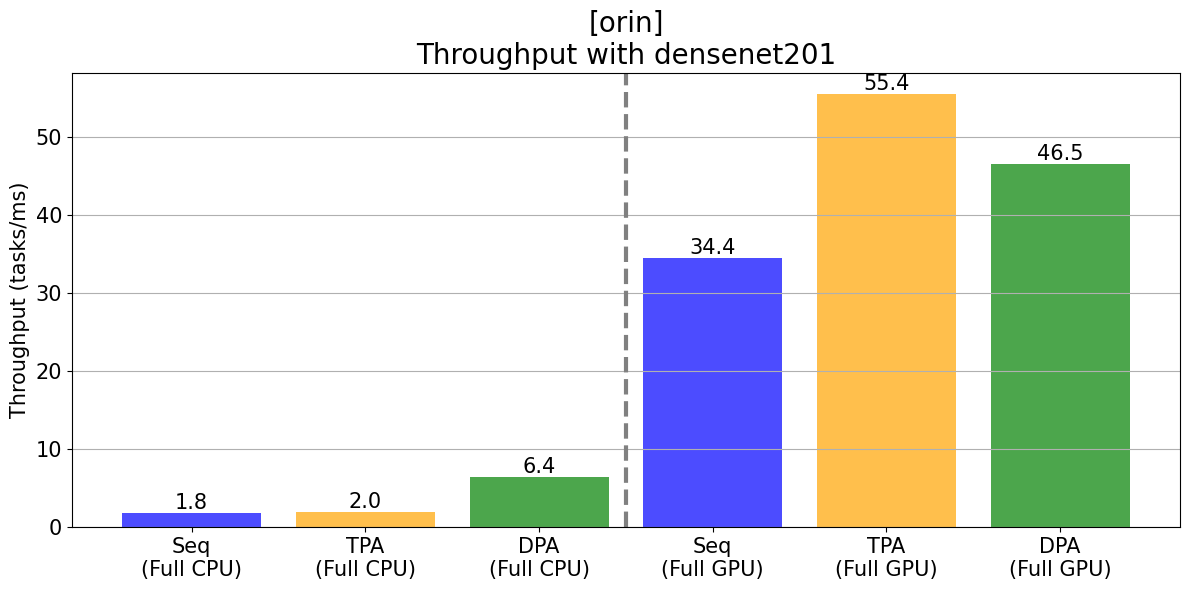

In [188]:
fig = plt.figure(figsize=(12, 6))

    
# 첫 번째 그래프: Average Frame Rate
bars1 = plt.bar(throughput.keys(), throughput.values(), color=colors[:3], alpha=0.7)
plt.ylabel('Throughput (tasks/ms)', size = 15)
plt.title(f'[{device}]\nThroughput with {model}', size = 20)
plt.grid(True, axis = 'y')
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=3)  # x=2.5 위치에 점선 추가

# 막대 위에 텍스트 추가
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', size = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{date_label}/{save_format}/Throughput-{device}-{type}-{model}-{date_label}.{save_format}')

##### 2. Average Execution Time

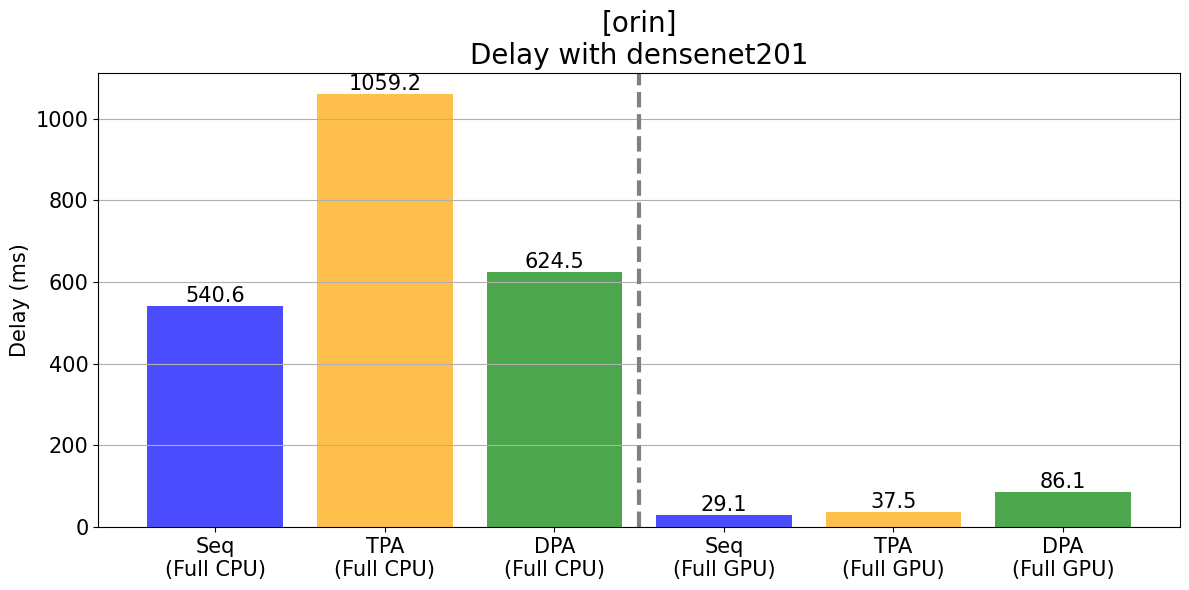

In [189]:
fig = plt.figure(figsize=(12, 6))

# 두 번째 그래프: Average Execution Time
bars2 = plt.bar(average_execution_times.keys(), average_execution_times.values(), color=colors[:3], alpha=0.7)
plt.ylabel('Delay (ms)', size = 15)
plt.title(f'[{device}]\nDelay with {model}', size = 20)
plt.grid(True, axis = 'y')
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=3)  # x=2.5 위치에 점선 추가

# 막대 위에 텍스트 추가
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', size = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{date_label}/{save_format}/Delay-{device}-{type}-{model}-{date_label}.{save_format}')

##### 3. Block Loss / Pipeline stall

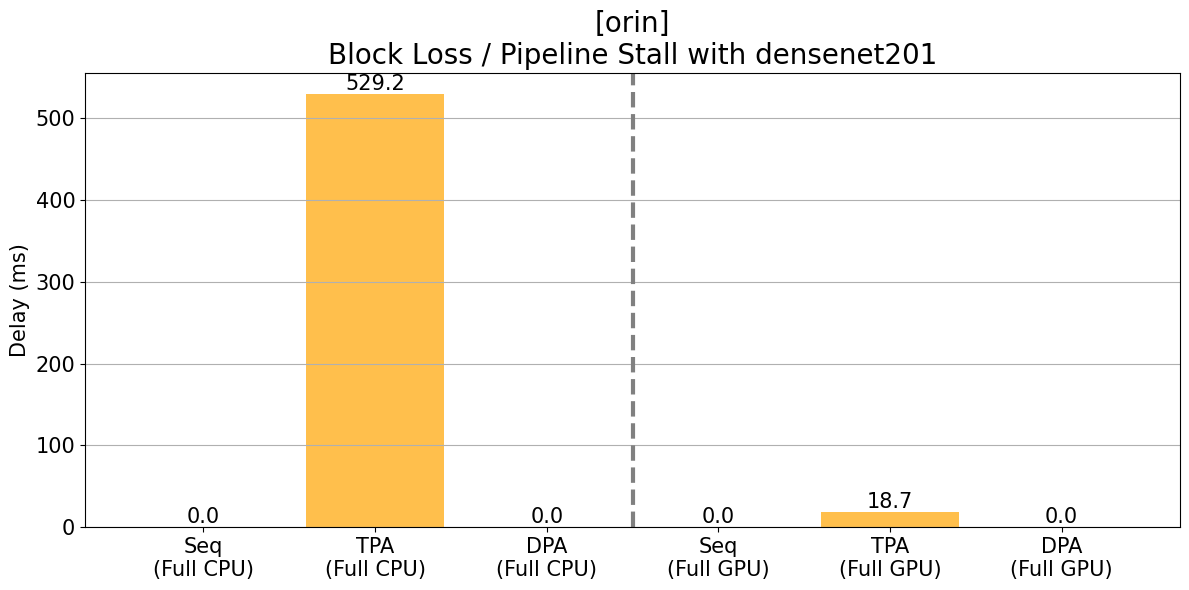

In [190]:
fig = plt.figure(figsize=(12, 6))

# tp 번째 그래프: Block Loss
bars3 = plt.bar(block_losses.keys(), block_losses.values(), color=colors[:3], alpha=0.7)
plt.ylabel('Delay (ms)', size = 15)
plt.title(f'[{device}]\nBlock Loss / Pipeline Stall with {model}', size = 20)
plt.grid(True, axis = 'y')
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=3)  # x=2.5 위치에 점선 추가

# 막대 위에 텍스트 추가
for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', size = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{date_label}/{save_format}/BlockLoss-{device}-{type}-{model}-{date_label}.{save_format}')

##### 4. Acceleration Gain

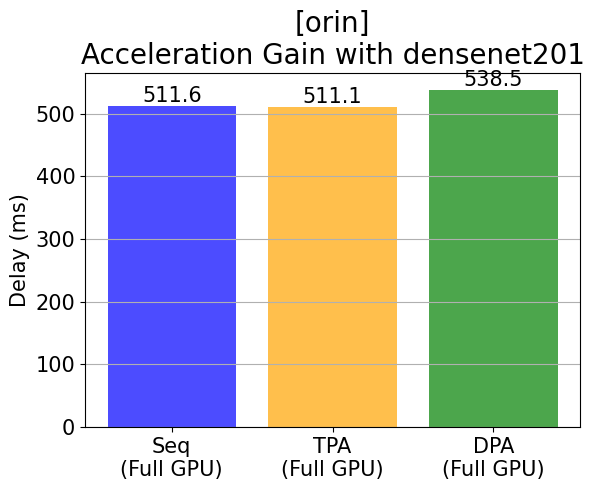

In [191]:
fig = plt.figure(figsize=(6, 5))

# 네 번째 그래프: Acceleration Gain
bars4 = plt.bar(accel_gains.keys(), accel_gains.values(), color=colors, alpha=0.7)
plt.ylabel('Delay (ms)', size = 15)
plt.title(f'[{device}]\nAcceleration Gain with {model}', size = 20)
plt.grid(True, axis = 'y')
plt.tick_params(labelsize=15)

# 막대 위에 텍스트 추가
for bar in bars4:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', size = 15)
plt.tick_params(labelsize=15)
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{date_label}/{save_format}/Acceleration_gain-{device}-{type}-{model}-{date_label}.{save_format}')

##### 5. Delay Component

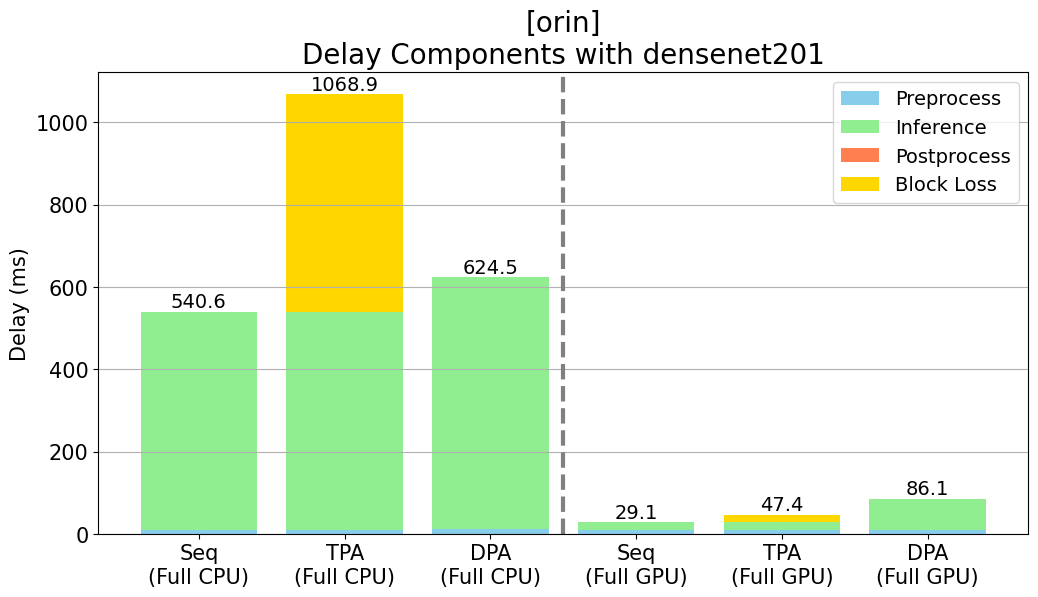

In [192]:
plt.figure(figsize=(12, 6))
x_labels = list(pre_components.keys())
pre_values = np.array(list(pre_components.values()))
infer_values = np.array(list(infer_components.values()))
post_values = np.array(list(post_components.values()))
block_values = np.array(list(block_components.values()))

# 첫 번째 그래프: Delay Components
bar1 = plt.bar(x_labels, pre_values, color='skyblue', label='Preprocess')
bar2 = plt.bar(x_labels, infer_values, color='lightgreen',bottom=np.array(pre_values), label='Inference')
bar3 = plt.bar(x_labels, post_values, bottom=np.array(pre_values) + np.array(infer_values), color='coral', label='Postprocess')
bar4 = plt.bar(x_labels, block_values,
               bottom=np.array(pre_values) + np.array(infer_values) + np.array(post_values),
               color='gold', label='Block Loss')

# 막대 위에 텍스트 추가
for i in range(6):
    total_height = (pre_values[i] + infer_values[i] +
                    post_values[i] + block_values[i])
    plt.text(i, total_height, f'{total_height:.1f}', ha='center', va='bottom', fontsize=14)

plt.legend(fontsize=14)
plt.ylabel('Delay (ms)', size = 15)
plt.title(f'[{device}]\nDelay Components with {model}', size = 20)
plt.grid(True, axis = 'y')
plt.axvline(x=2.5, color='gray', linestyle='--', linewidth=3)  # x=2.5 위치에 점선 추가
plt.tick_params(labelsize=15)
for save_format in save_formats:
    plt.savefig(f'./{date_label}/{save_format}/Components-{device}-{type}-{model}-{date_label}.{save_format}')